## CS536: Computing Solutions
#### Done by: Vedant Choudhary, vc389

### Linear Regression
Consider data generated in the following way:

- $X_1$ through $X_{10}$ and $X_{16}$ through $X_{20}$ are i.i.d. standard normals
- $X_{11} = X_1 + X_2 + N (\mu=0, \sigma^2=0.1)$
- $X_{12} = X_3 + X_4 + N (\mu=0, \sigma^2=0.1)$
- $X_{13} = X_4 + X_5 + N (\mu=0, \sigma^2=0.1)$
- $X_{14} = 0.1X_7 + N (\mu=0, \sigma^2=0.1)$
- $X_{15} = 2X_2 - 10 +N (\mu=0, \sigma^2=0.1)$

The values $Y$ are generated according to the following linear model:
$$ Y = 10 + \sum_{i=1}^10{(0.6)^iX_i} $$

Note, the variables $X_{11}$ through $X_{20}$ are technically irrelevant

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm

%matplotlib inline

#### 1. Generate a data set of size m = 1000. Solve the naive least squares regression model for the weights and bias that minimize the training error - how do they compare to the true weights and biases? What did your model conclude as the most significant and least significant features - was it able to prune anything? Simulate a large test set of data and estimate the ‘true’ error of your solved model.

In [2]:
# Creating X (feature) vectors for the data
def create_data(m):
    X_1_10 = np.random.normal(0, 1, (m,11))
    X_11 = np.asarray([X_1_10[i][1] + X_1_10[i][2] + np.random.normal(loc=0, scale=(0.1)**(0.5)) for i in range(m)]).reshape((-1,1))
    X_12 = np.asarray([X_1_10[i][3] + X_1_10[i][4] + np.random.normal(loc=0, scale=(0.1)**(0.5)) for i in range(m)]).reshape((-1,1))
    X_13 = np.asarray([X_1_10[i][4] + X_1_10[i][5] + np.random.normal(loc=0, scale=(0.1)**(0.5)) for i in range(m)]).reshape((-1,1))
    X_14 = np.asarray([0.1*X_1_10[i][7] + np.random.normal(loc=0, scale=(0.1)**(0.5)) for i in range(m)]).reshape((-1,1))
    X_15 = np.asarray([2*X_1_10[i][2] - 10 + np.random.normal(loc=0, scale=(0.1)**(0.5)) for i in range(m)]).reshape((-1,1))
    X_16_20 = np.random.normal(0, 1, (m, 5))

    return np.concatenate((X_1_10, X_11, X_12, X_13, X_14, X_15, X_16_20), axis=1)

# Creating target column for the data
def create_y(X, m):
    y = []
    for i in range(m):
        temp = 10
        for j in range(1, 11):
            temp += ((0.6)**j)*X[i][j]
        y.append(temp)
        
    return np.asarray(y)

# Combining all the sub data points into a dataframe
def create_dataset(m):
    X = create_data(m)
    y = create_y(X, m).reshape((m,1))
    X = X[:,1:]
    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(1,21)]+['Y'])
    return data

In [3]:
m = 1000

train_data = create_dataset(m)
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,0.072365,-0.104326,-1.017031,-1.674365,1.001804,1.197790,1.165103,0.661097,0.309791,-3.009013,...,-2.748646,-0.385016,0.095815,-10.493530,1.395603,-0.162316,-0.495704,-1.467413,-0.692373,9.731616
1,-1.961036,0.340253,-0.548020,-1.489851,1.103784,-0.558033,-1.946251,-2.038110,-1.222546,-0.005187,...,-1.953423,-0.717352,-0.180953,-9.521496,-0.329063,0.740168,1.352207,-1.425790,-1.629125,8.593140
2,-0.243981,-0.549543,-1.689627,0.594063,-1.323547,0.123544,0.217980,-0.446333,-0.362177,-0.780921,...,-1.005382,-1.078281,-0.023008,-11.103933,0.973920,-0.820661,-0.087921,-1.088524,0.548099,9.260886
3,-0.167967,0.775158,1.020493,-0.151275,-0.955532,-0.121407,0.363101,-1.251602,-1.692017,-0.212458,...,1.106357,-1.597547,0.138699,-8.158180,-0.258212,2.220531,0.472591,-1.005993,-0.855939,10.269937
4,-1.325328,-0.376547,-0.623416,0.093823,-0.074619,-1.256950,-0.749450,0.799188,0.962763,-1.465720,...,-0.549299,-0.391568,-0.075421,-11.013280,1.138539,0.342026,1.030551,0.546390,1.914319,8.875585


In [37]:
class LinearRegression():
    def __init__(self):
        pass
    
    def naive_regression(self, X, y, alpha=0.01, iters=100):
#         Initialize the parameters
        n_samples, n_features = X.shape
        self.w = np.zeros(shape=(n_features,1))
        self.b = 0
        
        cost_fn = []
        
        for i in range(iters):
#             Predicted value
            y_hat = np.dot(X, self.w) + self.b
#             Cost function
            cost = (1/(2*n_samples))*np.sum((y_hat-y)**2)
            cost_fn.append(cost)
        
            if i%10 == 0:
                print("Cost at iteration {} is {}".format(i, cost))
                
#             Compute grad desc. partial derivatives
            dJ_dw = (1/n_samples)*np.dot(X.T, (y_hat - y))
#             if i%10 == 0:
#                 print(dJ_dw)
            dJ_db = (1/n_samples)*np.sum(y_hat - y)
#             Update parameters
            self.w = self.w - alpha*dJ_dw
            self.b = self.b - alpha*dJ_db
        
        return self.w, self.b, cost_fn
    
    def ridge_regression(self, X, y, alpha=0.01, iters=100, lmbda = 2.5):
#         Initialize the parameters
        n_samples, n_features = X.shape
        self.w = np.zeros(shape=(n_features,1))
        self.b = 0
        
        cost_fn = []
        
        for i in range(iters):
#             Predicted value
            y_hat = np.dot(X, self.w) + self.b
#             Cost function
            cost = (1/(2*n_samples))*np.sum((y_hat-y)**2) + (1/(2*n_samples))*lmbda*np.sum((self.w))**2
            cost_fn.append(cost)
        
            if i%100 == 0:
                print("Cost at iteration {} is {}".format(i, cost))
                
#             Compute grad desc. partial derivatives
            dJ_dw = (1/n_samples)*np.dot(X.T, (y_hat - y)) + lmbda*self.w
            dJ_db = (1/n_samples)*np.sum(y_hat - y)
#             Update parameters
            self.w = self.w - alpha*dJ_dw
            self.b = self.b - alpha*dJ_db
        
        return self.w, self.b, cost_fn
    
    def predict(self, X):
        return np.dot(X, self.w) + self.b

Cost at iteration 0 is 50.127255664465714
Cost at iteration 10 is 2.3046988407593463
Cost at iteration 20 is 1.835275379563715
Cost at iteration 30 is 1.4791603827272803
Cost at iteration 40 is 1.2072884750050112
Cost at iteration 50 is 0.9982575242985479
Cost at iteration 60 is 0.8362747515245458
Cost at iteration 70 is 0.709665518070587
Cost at iteration 80 is 0.6097816831896393
Cost at iteration 90 is 0.5302018162670709


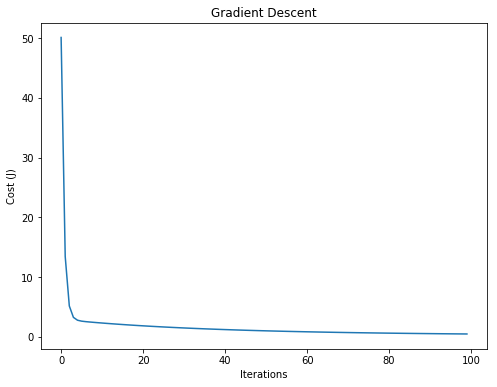

In [38]:
lin_reg = LinearRegression()
w_trained, b_trained, costJ = lin_reg.naive_regression(X = np.asarray(train_data.iloc[:,:-1]), y = np.asarray(train_data.iloc[:,-1:]), alpha=0.005, iters=100)

# print(w_trained, b_trained)
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(100), costJ)
plt.title("Gradient Descent")
plt.xlabel("Iterations")
plt.ylabel("Cost (J)")
plt.show()

Cost at iteration 0 is 50.127255664465714
[[ 4.46004657e-02]
 [ 4.18896746e-01]
 [ 4.25082267e-02]
 [ 2.46648552e-04]
 [ 9.42145219e-04]
 [ 1.29710393e-02]
 [-1.17216983e-02]
 [ 3.88748239e-04]
 [ 1.38976293e-02]
 [-1.61415375e-02]
 [ 4.64655596e-01]
 [ 3.81258355e-02]
 [ 5.67162801e-04]
 [-4.67497606e-03]
 [-9.13586505e-01]
 [ 1.46653705e-02]
 [-2.09586942e-02]
 [ 5.27686317e-03]
 [ 8.92496239e-03]
 [-2.43576270e-02]] 0.36162148370606245


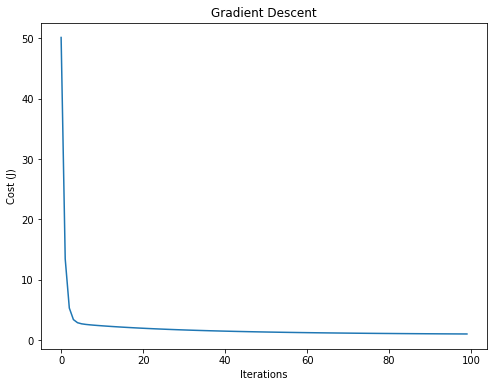

In [40]:
w_lmbda_trained, b_lmbda_trained, costJ = lin_reg.ridge_regression(X = np.asarray(train_data.iloc[:,:-1]), y = np.asarray(train_data.iloc[:,-1:]), alpha=0.005, iters=100, lmbda=2.5)

print(w_lmbda_trained, b_lmbda_trained)
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(100), costJ)
plt.title("Gradient Descent")
plt.xlabel("Iterations")
plt.ylabel("Cost (J)")
plt.show()

In [24]:
np.sum(np.asarray([1, 2 ,3 ,4]) - np.asarray([1, 1, 1, 1]))

6